In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import pandas as pd



def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file if line.strip()]
        return lines



eng_file_path = '/content/drive/MyDrive/[English (auto-generated)] FULL MATCH_ Portugal v Spain _ 2018 FIFA World Cup [DownSub.com] (1).txt'  # Update with your actual file path
esp_file_path = '/content/drive/MyDrive/[Spanish (auto-generated)] Full Match - Barcelona vs Villarreal HD 1080i Spanish Commentary (02_12_2018) [DownSub.com].txt'
eng_sentences = read_file(eng_file_path)
esp_sentences = read_file(esp_file_path)


In [ ]:
# Filter out stuff like [applause] and [music]
eng_sentences = [sentence for sentence in eng_sentences if not sentence.startswith('[')]
esp_sentences = [sentence for sentence in esp_sentences if not sentence.startswith('[')]

In [ ]:
print(len(eng_sentences))
len(esp_sentences)

1469


2531

In [ ]:
# Randomly sample from spanish to make length equal to english
import random
esp_sentences = random.sample(esp_sentences, 1469)


In [ ]:
from sklearn.model_selection import train_test_split
train_eng_sentences, test_eng_sentences, train_esp_sentences, test_esp_sentences = train_test_split(
    eng_sentences, esp_sentences, test_size=0.2, random_state=42
)

In [ ]:
english_spanish_pairs = pd.read_csv('/content/drive/MyDrive/english_spanish_pairs.tsv', sep = '\t')
english_spanish_pairs.columns = ['spanish_id', 'spanish_sentence','english_id','english_sentence']
english_spanish_pairs = english_spanish_pairs.sample(frac=0.1, random_state=42)

# Ensure the sentences are strings
english_spanish_pairs['spanish_sentence'] = english_spanish_pairs['spanish_sentence'].astype(str)
english_spanish_pairs['english_sentence'] = english_spanish_pairs['english_sentence'].astype(str)


In [ ]:
# Tokenizing the sentences
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')


# Tokenize each sentence into words
tokenized_eng_sentences = [word_tokenize(sentence.lower()) for sentence in train_eng_sentences]
tokenized_esp_sentences = [word_tokenize(sentence.lower()) for sentence in train_esp_sentences]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Train a Word2Vec model
model = Word2Vec(tokenized_eng_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model.save("word2vec_english_model.model")

# To load the model later
eng_loaded_model = Word2Vec.load("word2vec_english_model.model")


In [ ]:
# Train a Word2Vec model
model = Word2Vec(tokenized_esp_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model.save("word2vec_spanish_model.model")

# To load the model later
esp_loaded_model = Word2Vec.load("word2vec_spanish_model.model")

In [ ]:
import numpy as np

# Function to compute the average vector for a sentence
def sentence_to_avg_vector(sentence, model):
    words = word_tokenize(sentence.lower())
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

english_test_vectors = np.array([sentence_to_avg_vector(sentence, eng_loaded_model) for sentence in test_eng_sentences])
spanish_test_vectors = np.array([sentence_to_avg_vector(sentence, esp_loaded_model) for sentence in test_esp_sentences])


In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 941.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


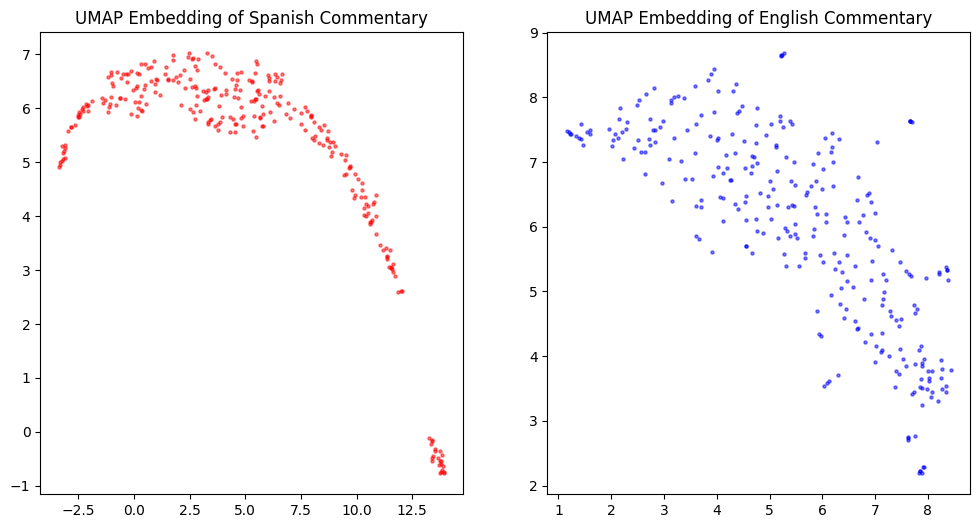

In [ ]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP to reduce dimensionality to 2D
umap_model_spanish = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=34)
spanish_embedding = umap_model_spanish.fit_transform(spanish_test_vectors)

umap_model_english = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=34)
english_embedding = umap_model_english.fit_transform(english_test_vectors)

# Plot the UMAP embeddings
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(spanish_embedding[:, 0], spanish_embedding[:, 1], s=5, c='red', alpha=0.5)
plt.title("UMAP Embedding of Spanish Commentary")

plt.subplot(1, 2, 2)
plt.scatter(english_embedding[:, 0], english_embedding[:, 1], s=5, c='blue', alpha=0.5)
plt.title("UMAP Embedding of English Commentary")

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


# Define the generator network (linear transformation)
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        return self.linear(x)

# Define the more complex generator network
class ComplexGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ComplexGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize networks
input_dim = 100  # Dimension of the word vectors
generator = Generator(input_dim, input_dim)
discriminator = Discriminator(input_dim)

# Optimizers
lr_gen = 0.01  # Lower learning rate for generator
lr_dis = 0.1
optimizer_G = optim.SGD(generator.parameters(), lr=lr_gen)
optimizer_D = optim.SGD(discriminator.parameters(), lr=lr_dis)

# Loss function
criterion = nn.BCELoss()

# Prepare data
spanish_vectors = torch.tensor(spanish_test_vectors, dtype=torch.float32)
english_vectors = torch.tensor(english_test_vectors, dtype=torch.float32)

# Create labels
real_labels = torch.ones(english_vectors.size(0), 1)
fake_labels = torch.zeros(spanish_vectors.size(0), 1)

# Create data loaders
batch_size = 32
dataset = TensorDataset(spanish_vectors, english_vectors)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    with tqdm(total=len(data_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, (spanish_batch, english_batch) in enumerate(data_loader):

            # Train discriminator
            optimizer_D.zero_grad()
            real_output = discriminator(english_batch)
            real_loss = criterion(real_output, real_labels[:english_batch.size(0)])

            fake_english = generator(spanish_batch)
            fake_output = discriminator(fake_english.detach())
            fake_loss = criterion(fake_output, fake_labels[:spanish_batch.size(0)])

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train generator
            optimizer_G.zero_grad()
            fake_english = generator(spanish_batch)
            fake_output = discriminator(fake_english)
            g_loss = criterion(fake_output, real_labels[:spanish_batch.size(0)])

            g_loss.backward()
            optimizer_G.step()

            # Update progress bar
            pbar.set_postfix({"Discriminator Loss": d_loss.item(), "Generator Loss": g_loss.item()})
            pbar.update(1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')

print("Training complete")

# Save the models
torch.save(generator.state_dict(), 'generator3.pth')
torch.save(discriminator.state_dict(), 'discriminator3.pth')

print("Models saved successfully")


Epoch 1/20: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s, Discriminator Loss=1.38, Generator Loss=0.698]


Epoch [1/20], Discriminator Loss: 1.3831138610839844, Generator Loss: 0.6983084678649902


Epoch 2/20: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s, Discriminator Loss=1.38, Generator Loss=0.696]


Epoch [2/20], Discriminator Loss: 1.3817845582962036, Generator Loss: 0.6962147355079651


Epoch 3/20: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s, Discriminator Loss=1.38, Generator Loss=0.699]


Epoch [3/20], Discriminator Loss: 1.3782014846801758, Generator Loss: 0.6988350749015808


Epoch 4/20: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s, Discriminator Loss=1.37, Generator Loss=0.702]


Epoch [4/20], Discriminator Loss: 1.3734928369522095, Generator Loss: 0.7017786502838135


Epoch 5/20: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s, Discriminator Loss=1.37, Generator Loss=0.702]


Epoch [5/20], Discriminator Loss: 1.371964931488037, Generator Loss: 0.7023922801017761


Epoch 6/20: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s, Discriminator Loss=1.37, Generator Loss=0.705]


Epoch [6/20], Discriminator Loss: 1.366624116897583, Generator Loss: 0.7047803997993469


Epoch 7/20: 100%|██████████| 10/10 [00:01<00:00,  6.89it/s, Discriminator Loss=1.36, Generator Loss=0.71]


Epoch [7/20], Discriminator Loss: 1.357926845550537, Generator Loss: 0.7097496390342712


Epoch 8/20: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s, Discriminator Loss=1.35, Generator Loss=0.71]


Epoch [8/20], Discriminator Loss: 1.3549377918243408, Generator Loss: 0.709958016872406


Epoch 9/20: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s, Discriminator Loss=1.34, Generator Loss=0.722]


Epoch [9/20], Discriminator Loss: 1.340707778930664, Generator Loss: 0.721502959728241


Epoch 10/20: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s, Discriminator Loss=1.33, Generator Loss=0.723]


Epoch [10/20], Discriminator Loss: 1.3317689895629883, Generator Loss: 0.7230784893035889


Epoch 11/20: 100%|██████████| 10/10 [00:01<00:00,  7.69it/s, Discriminator Loss=1.34, Generator Loss=0.719]


Epoch [11/20], Discriminator Loss: 1.3377577066421509, Generator Loss: 0.7187929749488831


Epoch 12/20: 100%|██████████| 10/10 [00:01<00:00,  9.36it/s, Discriminator Loss=1.31, Generator Loss=0.735]


Epoch [12/20], Discriminator Loss: 1.311612606048584, Generator Loss: 0.7347301840782166


Epoch 13/20: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s, Discriminator Loss=1.3, Generator Loss=0.744]


Epoch [13/20], Discriminator Loss: 1.2966303825378418, Generator Loss: 0.7441592216491699


Epoch 14/20: 100%|██████████| 10/10 [00:00<00:00, 10.27it/s, Discriminator Loss=1.33, Generator Loss=0.716]


Epoch [14/20], Discriminator Loss: 1.3308420181274414, Generator Loss: 0.7157179713249207


Epoch 15/20: 100%|██████████| 10/10 [00:00<00:00, 11.07it/s, Discriminator Loss=1.27, Generator Loss=0.76]


Epoch [15/20], Discriminator Loss: 1.26924729347229, Generator Loss: 0.759502112865448


Epoch 16/20: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s, Discriminator Loss=1.26, Generator Loss=0.757]


Epoch [16/20], Discriminator Loss: 1.2642464637756348, Generator Loss: 0.757300615310669


Epoch 17/20: 100%|██████████| 10/10 [00:00<00:00, 10.01it/s, Discriminator Loss=1.22, Generator Loss=0.788]


Epoch [17/20], Discriminator Loss: 1.2198882102966309, Generator Loss: 0.7877063751220703


Epoch 18/20: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s, Discriminator Loss=1.22, Generator Loss=0.785]


Epoch [18/20], Discriminator Loss: 1.2243752479553223, Generator Loss: 0.7850663065910339


Epoch 19/20: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s, Discriminator Loss=1.24, Generator Loss=0.777]


Epoch [19/20], Discriminator Loss: 1.2390879392623901, Generator Loss: 0.7773751616477966


Epoch 20/20: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s, Discriminator Loss=1.24, Generator Loss=0.772]


Epoch [20/20], Discriminator Loss: 1.2429511547088623, Generator Loss: 0.7721121907234192
Training complete
Models saved successfully


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from nltk.tokenize import word_tokenize
import gensim
from sklearn.metrics.pairwise import cosine_similarity

# Initialize networks
input_dim = 100  # Dimension of the word vectors
generator = Generator(input_dim, input_dim)
discriminator = Discriminator(input_dim)

# Load the saved models
generator.load_state_dict(torch.load('generator3.pth'))
discriminator.load_state_dict(torch.load('discriminator3.pth'))

# Set the models to evaluation mode
generator.eval()
discriminator.eval()

# Ensure the required NLTK data is downloaded
import nltk

# Tokenize the sentences
english_spanish_pairs['spanish_tokenized'] = english_spanish_pairs['spanish_sentence'].apply(word_tokenize)
english_spanish_pairs['english_tokenized'] = english_spanish_pairs['english_sentence'].apply(word_tokenize)

# Function to get average word2vec embeddings
def get_avg_embedding(sentence_tokens, model):
    word_vectors = [model.wv[word] for word in sentence_tokens if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Assuming you have trained word2vec models as word2vec_model_spanish and word2vec_model_english
# Get embeddings for Spanish and English sentences
english_spanish_pairs['spanish_embedding'] = english_spanish_pairs['spanish_tokenized'].apply(lambda x: get_avg_embedding(x, esp_loaded_model))
english_spanish_pairs['english_embedding'] = english_spanish_pairs['english_tokenized'].apply(lambda x: get_avg_embedding(x, eng_loaded_model))

# Convert embeddings to PyTorch tensors
spanish_embeddings = torch.tensor(np.stack(english_spanish_pairs['spanish_embedding'].values), dtype=torch.float32)
english_embeddings = torch.tensor(np.stack(english_spanish_pairs['english_embedding'].values), dtype=torch.float32)

# Transform Spanish embeddings using the generator
spanish_to_english_embeddings = generator(spanish_embeddings).detach().numpy()

# Identity transformation (Spanish embeddings compared directly to English embeddings)
identity_transformation_embeddings = spanish_embeddings.detach().numpy()

# Calculate cosine similarity for generator transformation
similarities_generated = cosine_similarity(spanish_to_english_embeddings, spanish_embeddings)
average_similarity_generated = np.mean(np.diag(similarities_generated))

# Calculate cosine similarity for identity transformation
similarities_identity = cosine_similarity(identity_transformation_embeddings, english_embeddings)
average_similarity_identity = np.mean(np.diag(similarities_identity))

print(f'Average Cosine Similarity between translated Spanish embeddings and English embeddings (Generator): {average_similarity_generated:.4f}')
print(f'Average Cosine Similarity between original Spanish embeddings and English embeddings (Identity): {average_similarity_identity:.4f}')


Average Cosine Similarity between translated Spanish embeddings and English embeddings (Generator): 0.1039
Average Cosine Similarity between original Spanish embeddings and English embeddings (Identity): 0.6510


All embeddings are the same - only using 10 dimensions out of 100.

In [ ]:
# Step 2: Download the file from Google Drive
import gdown
url = 'https://drive.google.com/uc?id=10goKx-Yg1kxw5tBJDfVb5ISCd1q73vLI'
output = 'common_words.csv'
gdown.download(url, output, quiet=False)
# Step 3: Load the dataset into a pandas DataFrame
import pandas as pd
common_words = pd.read_csv(output)
common_words.columns = ['word']
# Assuming your dataset has a column 'word'
words = common_words['word'].tolist()
# Find k-nearest neighbors for a given word
word = 'ronaldo'
neighbors = eng_loaded_model.wv.most_similar(word, topn=5)
print('\n' + str(neighbors))
#Test translating from english to spanish
word = 'decir'
spanish_embeddings = esp_loaded_model.wv[word]
translated_embeddings = generator(torch.tensor(np.expand_dims(spanish_embeddings, axis=0))).detach().numpy()
translated_embeddings = np.squeeze(translated_embeddings)
# Find the most similar common English words
neighbors = eng_loaded_model.wv.similar_by_vector(translated_embeddings, topn=5)
print('\n' + str(neighbors))

Downloading...
From: https://drive.google.com/uc?id=10goKx-Yg1kxw5tBJDfVb5ISCd1q73vLI
To: /content/common_words.csv
100%|██████████| 37.4k/37.4k [00:00<00:00, 44.1MB/s]


[('the', 0.7374849915504456), ('and', 0.7042303681373596), ('a', 0.6840341091156006), ('in', 0.6691093444824219), ('for', 0.6685346961021423)]

[('pique', 0.2930851876735687), ('training', 0.28718578815460205), ('or', 0.27807044982910156), ('late', 0.27553603053092957), ('spell', 0.2685432732105255)]


In [ ]:
esp_loaded_model.wv.index_to_key

['de',
 'el',
 'que',
 'la',
 'en',
 'y',
 'a',
 'para',
 'del',
 'se',
 'con',
 'es',
 'un',
 'no',
 'por',
 'ha',
 'los',
 'al',
 'villarreal',
 'pero',
 'más',
 'le',
 'lo',
 'está',
 'partido',
 'dembélé',
 'alba',
 'muy',
 'va',
 'si',
 'una',
 'porque',
 'messi',
 'ese',
 'puede',
 'barça',
 'tiene',
 'primera',
 'ya',
 'equipo',
 'como',
 'otra',
 'mucho',
 'jordi',
 'vez',
 'este',
 'samu',
 'cazorla',
 'gerard',
 'desde',
 'rakitic',
 'las',
 'parte',
 'o',
 'esta',
 'falta',
 'balón',
 'dos',
 'su',
 'arturo',
 'busquets',
 'entre',
 'también',
 'valverde',
 'bueno',
 'jugada',
 'ahora',
 'jugadores',
 'vidal',
 'bien',
 'acción',
 'fuera',
 'jugador',
 'víctor',
 'piqué',
 'minutos',
 'hay',
 'pedraza',
 'cáceres',
 'estaba',
 'ruiz',
 'coutinho',
 'sergio',
 'arriba',
 'gol',
 'sí',
 'sin',
 'así',
 'momento',
 'segunda',
 'hecho',
 'álvaro',
 'derecha',
 'después',
 'ver',
 'mario',
 'me',
 'centro',
 'amarilla',
 'sobre',
 'esa',
 'barcelona',
 'juego',
 'ser',
 'casi',
 